# Modelo UNET
## Cofiguración de ambiente

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *


def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []
    num_filters = [32, 64, 128, 256]
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)
    return x, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    outputs = Concatenate()([outputs1, outputs1])

    model = Model(inputs, outputs)
    return model



In [67]:
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
def read_image(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def read_mask(y):
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred


def evaluate_normal(model, x_data, y_data):
    THRESHOLD = 0.5
    total = []
    for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        _, h, w, _ = x.shape

        y_pred1 = parse(model.predict(x)[0][..., -2])
        y_pred2 = parse(model.predict(x)[0][..., -1])
        
        line = np.ones((h, 10, 3)) * 255.0
        
        all_images = [
            x[0] * 255.0, line,
            mask_to_3d(y) * 255.0, line,
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]
        mask = np.concatenate(all_images, axis=1)
        cv2.imwrite(f"results/{i}.png", mask)

## Funciones de lectura de archivos y máscaras

In [4]:
import os
import numpy as np
import cv2
import json
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
# from model import build_model, Upsample, ASPP

def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

## Definición de métricas

In [5]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

## Lectura y preparación de archivos junto con sus máscaras

In [53]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from glob import glob
from sklearn.model_selection import train_test_split
# from model import build_model
# from utils import *
# from metrics import *

def read_image(x):
#     x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
#     y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([192, 256, 3])
    y.set_shape([192, 256, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset
   

## Carga de datos de entrenamiento y validación

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("files")

train_path = "/kaggle/input/d/daliaydom/cvcclinicdb/new_data/train"
valid_path = "/kaggle/input/d/daliaydom/cvcclinicdb/new_data/valid"

## Training
train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

## Shuffling
train_x, train_y = shuffling(train_x, train_y)

## Validation
valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))


## Configuramos los parámetros e hiperparámetros para la ejecucuón del modelo 

In [6]:
model_path = "files/model.h5"
batch_size = 16
epochs = 100
lr = 1e-4
shape = (192, 256, 3)

model = build_model(shape)
metrics = [
    dice_coef,
    iou,
    Recall(),
    Precision()
]

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

model.compile(loss=binary_crossentropy, optimizer=Adam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
    CSVLogger("files/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1



2022-12-03 23:08:42.145662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:08:42.146623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:08:42.334179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:08:42.335073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:08:42.335834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

5200 5200
61 61


## Ejecución del modelo

In [8]:
model.fit(train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks,
        shuffle=False)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-03 23:08:47.536822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-03 23:08:53.672569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/325 [..............................] - ETA: 1:40:22 - loss: 0.8796 - dice_coef: 0.1352 - iou: 0.0725 - recall: 0.7238 - precision: 0.0848

2022-12-03 23:09:06.272390: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 23:09:06.272437: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/325 [..............................] - ETA: 7:04 - loss: 0.8507 - dice_coef: 0.1787 - iou: 0.0987 - recall: 0.7949 - precision: 0.1182   

2022-12-03 23:09:07.469186: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 23:09:07.470780: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 23:09:07.639147: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1175 callback api events and 1169 activity events. 
2022-12-03 23:09:07.670740: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 23:09:07.714613: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_03_23_09_07

2022-12-03 23:09:07.740073: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_03_23_09_07/1769f82e88ba.trace.json.gz
2022-12-03 23:09:07.803898: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

325/325 [==============================] - 174s 479ms/step - loss: 0.4502 - dice_coef: 0.2503 - iou: 0.1439 - recall: 0.4835 - precision: 0.4552 - val_loss: 0.3805 - val_dice_coef: 0.1446 - val_iou: 0.0780 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
325/325 [==============================] - 132s 406ms/step - loss: 0.3077 - dice_coef: 0.3442 - iou: 0.2090 - recall: 0.5657 - precision: 0.7487 - val_loss: 0.2465 - val_dice_coef: 0.3799 - val_iou: 0.2345 - val_recall: 0.5878 - val_precision: 0.7778
Epoch 3/100
325/325 [==============================] - 131s 404ms/step - loss: 0.2348 - dice_coef: 0.4235 - iou: 0.2700 - recall: 0.6219 - precision: 0.7965 - val_loss: 0.2082 - val_dice_coef: 0.4271 - val_iou: 0.2728 - val_recall: 0.6382 - val_precision: 0.8167
Epoch 4/100
325/325 [==============================] - 132s 407ms/step - loss: 0.1819 - dice_coef: 0.5094 - iou: 0.3434 - recall: 0.6755 - precision: 0.8477 - val_loss: 0.1597 - val_dice_coef: 0.5128 - val_iou: 0.34

In [11]:
!zip -r "files.zip" "/kaggle/working/"

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/files/ (stored 0%)
  adding: kaggle/working/files/data.csv (deflated 53%)
  adding: kaggle/working/files/model.h5 (deflated 13%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/validation/ (stored 0%)
  adding: kaggle/working/logs/validation/events.out.tfevents.1670109099.1769f82e88ba.23.1.v2 (deflated 79%)
  adding: kaggle/working/logs/train/ (stored 0%)
  adding: kaggle/working/logs/train/events.out.tfevents.1670108927.1769f82e88ba.23.0.v2 (deflated 91%)
  adding: kaggle/working/logs/train/plugins/ (stored 0%)
  adding: kaggle/working/logs/train/plugins/profile/ (stored 0%)
  adding: kaggle/working/logs/train/plugins/profile/2022_12_03_23_09_07/ (stored 0%)
  adding: kaggle/working/logs/train/plugins/profile/2022_12_03_23_09_07/1769f82e88ba.kernel_stats.pb (deflated 93%)
  add

In [1]:
def grafico_hist(history):
    fig = plt.gcf()
    fig.set_size_inches(20, 9)

    plt.subplot(2,3,1)
    plt.title('Loss')
    plt.xlabel("epoch")
    plt.plot(history['loss'], color='red', label='train')
    plt.plot(history['val_loss'],color ='blue',label='validation')
    plt.legend(['train', 'val'], loc='upper right')

    plt.subplot(2,3,2)
    plt.title('mIOU')
    plt.xlabel("epoch")
    plt.plot(history['iou'], color='red', label='train')
    plt.plot(history['val_iou'], color='blue', label='validation')
    plt.legend(['train', 'val'], loc='lower right')
    
    plt.subplot(2,3,3)
    plt.title('Precision')
    plt.xlabel("epoch")
    plt.plot(history['precision'], color='red', label='train')
    plt.plot(history['val_precision'], color='blue', label='validation')
    plt.legend(['train', 'val'], loc='lower right')
    
    plt.show()
    
    return

## Vista de gráficos de desempeño

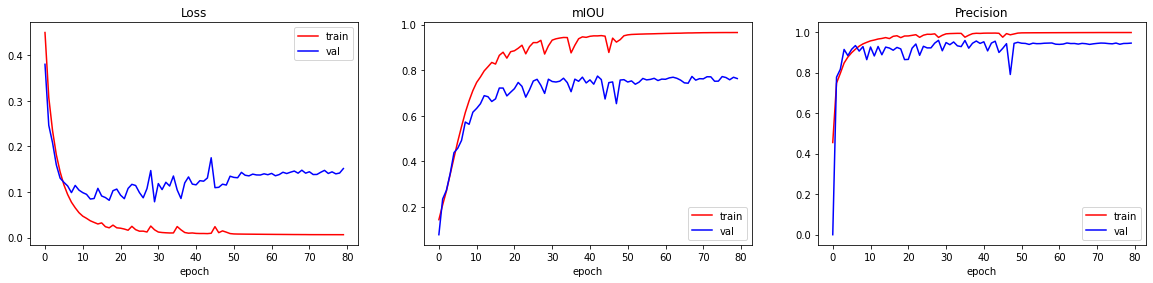

In [2]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

PATH_HISTORY = "/kaggle/input/files-unet-cvc/files/kaggle/working/files/data.csv"
history = pd.read_csv(PATH_HISTORY)
grafico_hist(history)

In [7]:
shape = (192, 256, 3)
model = build_model(shape)

2022-12-05 02:29:53.537965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:29:53.539021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:29:53.903563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:29:53.904806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:29:53.905602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## Generación de de predicciones

In [64]:
test_path = "/kaggle/input/test-cvc/test"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
# print(test_x,test_y)
np.random.seed(42)
tf.random.set_seed(42)
create_dir("results/")
m = load_model_weight(model_path)
evaluate_normal(m, test_x, test_y)

100%|██████████| 61/61 [00:09<00:00,  6.20it/s]


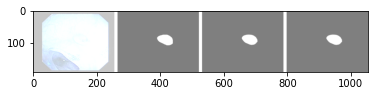

In [75]:
results = "/kaggle/working/results"
test = sorted(glob(results+'/*'))
x = read_image(test[15])
plt.imshow(x[0])
plt.show()
